In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brentq

from scipy.optimize import fsolve
from decimal import *
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Defining the likelihood function
def likelihood(x,w,s):
    return 1/(np.sqrt(2*np.pi)*s)*np.exp(-1/(2*s**2)*(w-1/x)**2)

#Defining the priors
def uniform_distance_prior(x, r_lim):
    if x > 0 and x <= r_lim:
      return 1/r_lim
    else:
      return 0

def uniform_density_prior(x, r_lim):
    if x > 0 and x <= r_lim:
      return (3/r_lim**3)*(x**2)
    else:
      return 0

def exponentially_decreasing_space_density_prior(x, L):
    if x > 0:
      return (1/2*L**3)*(x**2)*(np.exp(-x/L))
    else:
      return 0

In [3]:
#Calculate the posteriors
def uniform_distance_posterior(x,w,s,r_lim):    
    if x > 0 and x <= r_lim:
        return float(np.exp(float(-(w-1/x)**2/(2*s**2))))/(s*np.sqrt(2*np.pi)*r_lim)
    else:
        return 0

def uniform_density_posterior(x,w,s,r_lim):    
    if x > 0 and x <= r_lim:
        return float((x**2)*(np.exp(float(-(w-1/x)**2/(2*s**2)))))
    else:
        return 0
    
def exponentially_decreasing_space_density_posterior(x,w,s,L):
    if x > 0:
        return x**2*np.exp(-x/L)*np.exp(-(w-1/x)**2/(2*s**2))/(s*np.sqrt(2*np.pi)*2*L**3)
    else:
        return 0

In [4]:
#Calculate mode for every posterior
def mode_r_uniform_distance(w, r_lim): # Mode according to the uniform distance PDF posterior
    # If the distance computed as the invers of the parallax is not positive or inferior than r_lim the estimated distance is r_lim
    r = 1./w
    if (r <= r_lim) and (r > 0):
        r_mo = r
    else:
        r_mo = r_lim
    return r_mo

def mode_r_uniform_density(w, s, r_lim, f): # Mode according to the uniform distance PDF posterior
    # If the distance computed as the invers of the parallax is not positive or inferior than r_lim the estimated distance is r_lim
    r = (1/(4*(f**2)*s))*(1-np.sqrt(1-8*(f**2)))
    if (r <= r_lim) and (w > 0) and (f < 1/np.sqrt(8)):
        r_mo = r
    else:
        r_mo = r_lim
    return r_mo

def mode_r_exponential(L, w, sig_w): 
    a = np.float64(1. / L)
    b = np.float64(-2.)
    c = np.float64(w / sig_w ** 2)
    d = np.float64(- 1. / sig_w ** 2)

    p = np.array([a, b, c, d])

    sol = np.roots(p) #Solving the third degree equation

    l = len(sol)
    solutions = []

    for s in sol:
        if abs(s) == s: #Selecting the real roots
            solutions.append(s)

    # Given the physical limitations s>0 and L>0, only two cases are possible:
    # - All three roots are real and there are two modes and one minimum. If w>0 the solution is the smallest one while if w<0, the greatest one
    # is the solution.
    # - There's only one root.
    if len(solutions) == 3:  # If there are three real roots and the observed parallax is positive, the maximum value will be taken as the solution
        if w >= 0:
            r_mo = np.float(min(solutions))

        else:
            r_mo = np.float(max(solutions))
    else:

        r_mo = np.float64(abs(solutions[0]))
    return r_mo

In [5]:
#Calculate the percentiles
def percentiles(f,r0,r_mode,w,s,par): # Given a distance (i.e. r_mode), it integrates the PDF from r0 to the given distance and returns the unnormalized percentile
    p = quad(f,r0,r_mode,args=(w,s,par),epsrel = 1e-12, epsabs = 1e-12)
    return p[0]

def normalized_percentile(p,n):
    tol = 10**(-25)
    if n == 0:
       
        n = tol
        if p == 0:
            p = tol
   
    return p/n

In [6]:
#Calculate normalization for the posterior
def normalization(f,par1,w,s,p,r_mode,par2): 
    N = quad(f, r_mode, par2, args=(w, s, par1),epsrel = 1e-11, epsabs = 1e-11) # We integrate the required posterior from the mode to infinity (par2)
    
    N = N[0] + p # p is the percentile corresponding to the mode, i.e. the integration of the PDF from r0 to r_mode
    
    return N

In [7]:
#Calculate the median
def median(f,w,s,par,par2,r_mode,p,N):
    r0 = 0.01 #kpc
    # The median is the distance which corresponds to the 50% percentile
    # par2 is the 'infinite' of every distribution
    
    if p == 0.5: # If the percentile of the mode = 0.5, the mode and the median coincide
        return r_mode
    
    else: # We try to find the smallest interval that we know contains the median
        if p>0.5: # If the mode is at the right of the median, the median will be between r0 and the mode
            r_inf = r0
            r_sup = r_mode
            
            def function(x):
                I = quad(f, r0, x, args=(w, s, par),epsrel = 1e-11, epsabs = 1e-11)
                return I[0]/N - 0.5

            r_median = brentq(function, r_inf, r_sup) #Finding the median

            return r_median


        else: # If the mode is at the left of the median, the median will be between the mode and the limit  
            r_inf = r_mode
            r_sup = r_mode
            i = 0
            step = 0.1
            def function(x):
                I = quad(f, r0, x, args=(w, s, par),epsrel = 1e-11, epsabs = 1e-11)
                return I[0]/N - 0.5
            
            while True:
                i = i + 1
                try:
                    r_median = brentq(function, r_inf, r_sup)
                    return r_median
                
                except ValueError:
                    r_sup = r_sup + step
                    
                if i == 10**3:
                    step = step/10
                    i = 0
                    r_sup = r_mode

In [8]:
#Calculate the distances from the percentiles
def distances_from_percentiles(f,N,w,s,stype,p_inf,p_sup,p_ref,r_ref,par,par2):    
    r0 = 0.01 #kpc
    if stype == 'inf': # I'm looking for the inferior distance bound
        r_inf = r0
        r_sub = r_ref # The inferior limit will be between 0 and the median
        
        def function(x):
            I = quad(f, r0, x, args=(w, s, par),epsrel = 1e-12, epsabs = 1e-12)
            return I[0] / N - p_inf
        
        r = brentq(function,r_inf,r_sub)
        
        return r

    else: #I'm looking for the superior distance bound
        def function(x):
            I = quad(f, r0, x, args=(w, s, par),epsrel = 1e-12, epsabs = 1e-12)
            return I[0] / N - p_sup
        
        if (quad(f, r0, r_ref, args=(w, s, par), epsrel=1e-12, epsabs=1e-12)[0] / N - p_sup)<0:
            r_inf = r_ref
            
        else:
            r_inf = r0
        
        if (quad(f, r0, r_inf, args=(w, s, par), epsrel=1e-12, epsabs=1e-12)[0] / N - 0.95)*(quad(f, r0, par2, args=(w, s, par), epsrel=1e-11, epsabs=1e-11)[0] / N - 0.95) < 0:
            r_sup = par2
            
            r = brentq(function,r_inf,r_sup)
            return r
            
        else:
            i = 0
            step = 1
            r_sup = r_ref
            while True:
                i = i + 1
                try:
                    r = brentq(function, r_inf, r_sup)
                    return r
                
                except ValueError:
                    r_sup = r_sup + step
                    
                if i == 10**3:
                    step = step/10
                    i = 0
                    r_sup = r_ref

In [9]:
data = pd.read_csv("distance-inference-dr3.csv")

data['f'] = abs(data['parallax_error'] / data['parallax'])
data

,designation,ra,dec,parallax,parallax_error,f
0,Gaia DR3 4267180339403392768,286.716913,0.276195,1.084924,0.033431,0.030814
1,Gaia DR3 5252403815119316480,152.625068,-64.267699,0.854356,1.282721,1.501388
2,Gaia DR3 1937745177867542656,348.434982,43.940704,1.042008,0.633289,0.607758
3,Gaia DR3 5971301282285218048,252.729717,-37.917215,0.587660,0.633092,1.077310
4,Gaia DR3 5953201637243132416,260.678787,-44.788772,-0.293376,0.619885,2.112941
5,Gaia DR3 6125916630291830144,186.180736,-50.756590,0.436940,0.216148,0.494685
6,Gaia DR3 6018228919573319936,245.577837,-39.059397,2.379563,0.831078,0.349257
7,Gaia DR3 5203483274312495872,144.849128,-77.016786,0.352183,0.185059,0.525462
8,Gaia DR3 4162615512253865856,263.432898,-12.341759,-0.283236,1.247819,4.405575
9,Gaia DR3 907389666087922816,121.199918,37.854632,0.513708,0.433948,0.844737


In [10]:
L = 1.35 #kpc
r_lim = 100 #kpc
r0 = 0.01 #kpc

w = data["parallax"][0] # mas PARALLAX
s = data["parallax_error"][0] #mas PARALLAX ERROR
f = abs(s/w)

p_inf = 0.05 # Normalized inferior percentile
p_sup = 0.95 # Normalized superior percentile

x = np.arange(r0,r_lim,r_lim/50000)

(0.75, 1.15)

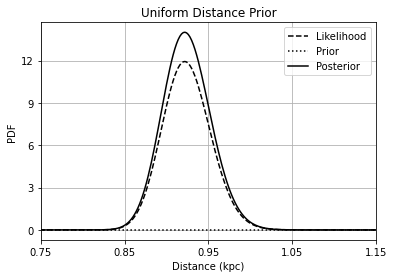

In [11]:
r_mode_ud = mode_r_uniform_distance(w, r_lim)

p_ud = percentiles(uniform_distance_posterior, r0, r_mode_ud, w, s,r_lim)
n_ud = normalization(uniform_distance_posterior, r_lim, w, s, p_ud, r_mode_ud,r_lim)
p_ud = normalized_percentile(p_ud, n_ud)

r_media_ud = median(uniform_distance_posterior,w,s,r_lim,r_lim,r_mode_ud,p_ud,n_ud)

r_sup_ud = distances_from_percentiles(uniform_distance_posterior, n_ud, w, s, 'sup', p_inf, p_sup,0.5, r_media_ud, r_lim, r_lim)
r_inf_ud = distances_from_percentiles(uniform_distance_posterior,n_ud,w,s,'inf',p_inf,p_sup,0.5,r_media_ud,r_lim,r_lim)

y1_ud = likelihood(x,w,s)
y2_ud = [uniform_distance_prior(i, r_lim) for i in x]  
y3_ud = [uniform_distance_posterior(i, w, s, r_lim)/n_ud for i in x]

plt.plot(x, y1_ud, label = "Likelihood", color = "black", linestyle = "dashed")
plt.plot(x, y2_ud, label = "Prior", color = "black", linestyle = "dotted")
plt.plot(x, y3_ud, label = "Posterior", color = "black")
plt.xlabel ("Distance (kpc)")
plt.ylabel ("PDF")
plt.title ("Uniform Distance Prior")
plt.xticks(np.arange(0.75, 1.25, step=0.10))
plt.yticks(np.arange(0, 15, step=3))

plt.legend ()
plt.grid ()
plt.xlim(0.75,1.15)

(0.75, 1.15)

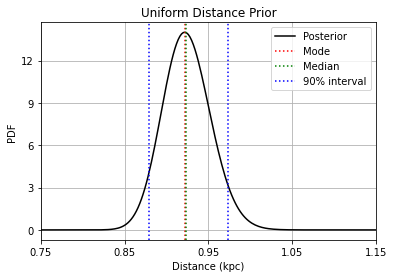

In [12]:
plt.plot(x, y3_ud, label = "Posterior", color = "black")
plt.axvline(x=r_mode_ud, label= "Mode", color = "red", linestyle = "dotted")
plt.axvline(x=r_media_ud, label= "Median", color = "green", linestyle = "dotted")
plt.axvline(x=r_inf_ud, label= "90% interval", color = "blue", linestyle = "dotted")
plt.axvline(x=r_sup_ud, color = "blue", linestyle = "dotted")
plt.xlabel ("Distance (kpc)")
plt.ylabel ("PDF")
plt.title ("Uniform Distance Prior")
plt.xticks(np.arange(0.75, 1.25, step=0.10))
plt.yticks(np.arange(0, 15, step=3))
plt.legend ()
plt.grid ()
plt.xlim(0.75,1.15)

(0.75, 1.15)

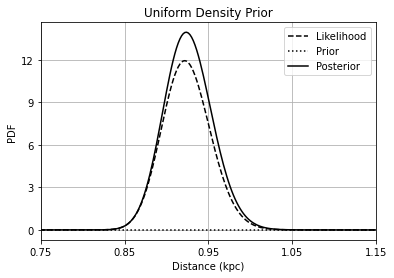

In [13]:
r_mode_usd = mode_r_uniform_density(w, s, r_lim, f)

p_usd = percentiles(uniform_density_posterior, r0, r_mode_usd, w, s,r_lim)
n_usd = normalization(uniform_density_posterior, r_lim, w, s, p_usd, r_mode_usd,r_lim)
p_usd = normalized_percentile(p_usd, n_usd)

r_media_usd = median(uniform_density_posterior,w,s,r_lim,r_lim,r_mode_usd,p_usd,n_usd)

r_sup_usd = distances_from_percentiles(uniform_density_posterior, n_usd, w, s, 'sup', p_inf, p_sup,0.5, r_media_usd, r_lim, r_lim)
r_inf_usd = distances_from_percentiles(uniform_density_posterior,n_usd,w,s,'inf',p_inf,p_sup,0.5,r_media_usd,r_lim, r_lim)

y1_usd = likelihood(x,w,s)
y2_usd = [uniform_density_prior(i, r_lim) for i in x]  
y3_usd = [uniform_density_posterior(i, w, s, r_lim)/n_usd for i in x]

plt.plot(x, y1_usd, label = "Likelihood", color = "black", linestyle = "dashed")
plt.plot(x, y2_usd, label = "Prior", color = "black", linestyle = "dotted")
plt.plot(x, y3_usd, label = "Posterior", color = "black")
plt.xlabel ("Distance (kpc)")
plt.ylabel ("PDF")
plt.title ("Uniform Density Prior")
plt.xticks(np.arange(0.75, 1.25, step=0.10))
plt.yticks(np.arange(0, 15, step=3))

plt.legend ()
plt.grid ()
plt.xlim(0.75,1.15)

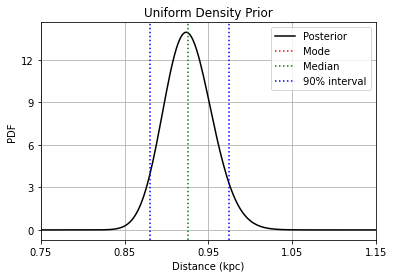

<Figure size 1440x1440 with 0 Axes>

In [14]:
plt.plot(x, y3_usd, label = "Posterior", color = "black")
plt.axvline(x=r_mode_usd, label= "Mode", color = "red", linestyle = "dotted")
plt.axvline(x=r_media_usd, label= "Median", color = "green", linestyle = "dotted")
plt.axvline(x=r_inf_usd, label= "90% interval", color = "blue", linestyle = "dotted")
plt.axvline(x=r_sup_usd, color = "blue", linestyle = "dotted")
plt.xlabel ("Distance (kpc)")
plt.ylabel ("PDF")
plt.title ("Uniform Density Prior")
plt.xticks(np.arange(0.75, 1.25, step=0.10))
plt.yticks(np.arange(0, 15, step=3))
plt.legend ()
plt.grid ()
plt.xlim(0.75,1.15)
plt.figure(figsize=(20,20))
plt.savefig("1_usd_2.png")

(0.75, 1.15)

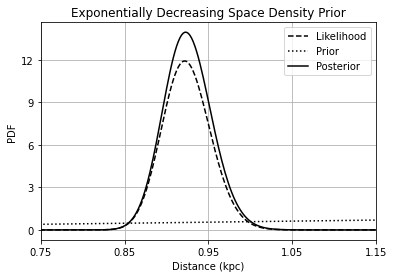

In [15]:
r_mode_exp = mode_r_exponential(L, w, s)

p_exp = percentiles(exponentially_decreasing_space_density_posterior,r0,r_mode_exp,w,s,L)# Computing the percentile that corresponds to the mode of the PDF
n_exp = normalization(exponentially_decreasing_space_density_posterior,L,w,s,p_exp,r_mode_exp,r_lim)# Computing the normalization constant of the PDF
p_exp = normalized_percentile(p_exp,n_exp) # Normalized percentile. The percentile now ranges from 0 to 1.
    
# Secondly, we can compute the median of the PDF, using as a reference the mode and its associated percentile (this allows to speed up the calculations)         
r_media_exp = median(exponentially_decreasing_space_density_posterior,w,s,L,r_lim,r_mode_exp,p_exp,n_exp)
    
# Finally, we compute the distances corresponding to the superior and inferior bound percentiles. We use the median of the PDF as a reference, since it divides the PDF into two halves
r_exp_inf = distances_from_percentiles(exponentially_decreasing_space_density_posterior, n_exp, w, s, 'inf', p_inf, p_sup,0.5, r_media_exp, L, r_lim)
r_exp_sup = distances_from_percentiles(exponentially_decreasing_space_density_posterior, n_exp, w, s, 'sup', p_inf, p_sup,0.5, r_media_exp, L, r_lim)

y1_exp = likelihood(x,w,s)
y2_exp = [exponentially_decreasing_space_density_prior(i, L) for i in x]  
y3_exp = [exponentially_decreasing_space_density_posterior(i,w,s,L)/n_exp for i in x]

plt.plot(x, y1_exp, label = "Likelihood", color = "black", linestyle = "dashed")
plt.plot(x, y2_exp, label = "Prior", color = "black", linestyle = "dotted")
plt.plot(x, y3_exp, label = "Posterior", color = "black")
plt.xlabel ("Distance (kpc)")
plt.ylabel ("PDF")
plt.title ("Exponentially Decreasing Space Density Prior")
plt.xticks(np.arange(0.75, 1.25, step=0.10))
plt.yticks(np.arange(0, 15, step=3))

plt.legend ()
plt.grid ()
plt.xlim(0.75,1.15)

(0.75, 1.15)

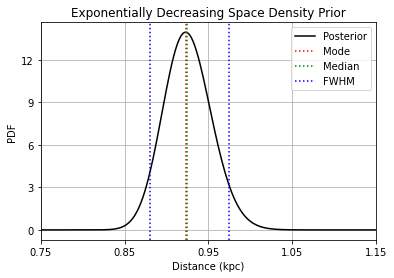

In [16]:
plt.plot(x, y3_exp, label = "Posterior", color = "black")
plt.axvline(x=r_mode_exp, label= "Mode", color = "red", linestyle = "dotted")
plt.axvline(x=r_media_exp, label= "Median", color = "green", linestyle = "dotted")
plt.axvline(x=r_exp_inf, label= "FWHM", color = "blue", linestyle = "dotted")
plt.axvline(x=r_exp_sup, color = "blue", linestyle = "dotted")
plt.xlabel ("Distance (kpc)")
plt.ylabel ("PDF")
plt.title ("Exponentially Decreasing Space Density Prior")
plt.xticks(np.arange(0.75, 1.25, step=0.10))
plt.yticks(np.arange(0, 15, step=3))
plt.legend ()
plt.grid ()
plt.xlim(0.75,1.15)